In [1]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline
from math import floor, sin


# Generate toy sinusoid dataset
def generate_sinusoid_data(n_points=1000):
    X = torch.linspace(0, 2 * math.pi, n_points, dtype=torch.float64).unsqueeze(1)
    y = torch.sin(X).squeeze() + 0.1 * torch.randn(X.size(0))
    return X, y


X, y = generate_sinusoid_data()

train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Test MAE: 0.10890580117523509


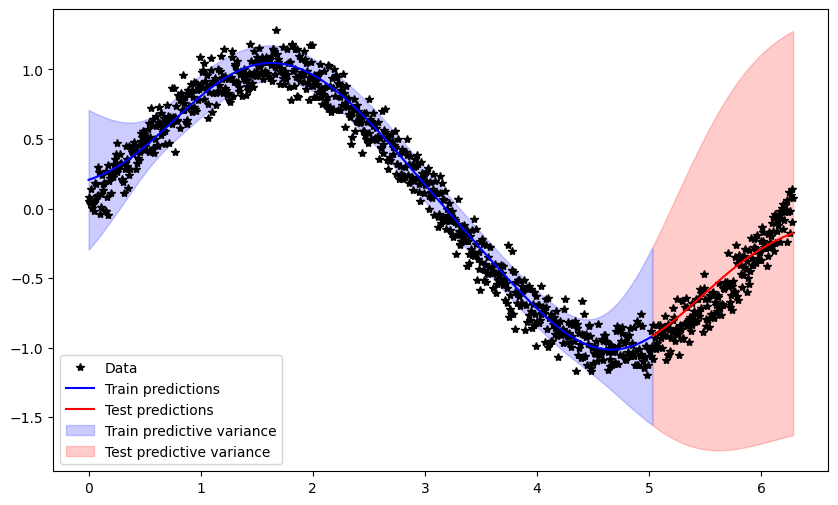

In [2]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution,
                                                   learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.double()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


inducing_points = train_x[:500, :]
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
num_epochs = 4

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

model.eval()
likelihood.eval()

# Predict on training data
train_means = torch.tensor([0.])
train_variances = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in DataLoader(train_dataset, batch_size=32, shuffle=False):
        preds = model(x_batch)
        train_means = torch.cat([train_means, preds.mean.cpu()])
        train_variances = torch.cat([train_variances, preds.variance.cpu()])
train_means = train_means[1:]
train_variances = train_variances[1:]

# Predict on test data
test_means = torch.tensor([0.])
test_variances = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        test_means = torch.cat([test_means, preds.mean.cpu()])
        test_variances = torch.cat([test_variances, preds.variance.cpu()])
test_means = test_means[1:]
test_variances = test_variances[1:]

print('Test MAE: {}'.format(torch.mean(torch.abs(test_means - test_y.cpu()))))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X.numpy(), y.numpy(), 'k*', label='Data')
plt.plot(train_x.cpu().numpy(), train_means.numpy(), 'b', label='Train predictions')
plt.plot(test_x.cpu().numpy(), test_means.numpy(), 'r', label='Test predictions')

# Plot training variance as a shaded area
train_x_np = train_x.cpu().numpy()
train_means_np = train_means.numpy()
train_variances_np = train_variances.numpy()
plt.fill_between(train_x_np.squeeze(),
                 train_means_np - 2 * train_variances_np ** 0.5,
                 train_means_np + 2 * train_variances_np ** 0.5,
                 color='b', alpha=0.2, label='Train predictive variance')

# Plot test variance as a shaded area
test_x_np = test_x.cpu().numpy()
test_means_np = test_means.numpy()
test_variances_np = test_variances.numpy()
plt.fill_between(test_x_np.squeeze(),
                 test_means_np - 2 * test_variances_np ** 0.5,
                 test_means_np + 2 * test_variances_np ** 0.5,
                 color='r', alpha=0.2, label='Test predictive variance')

plt.legend()
plt.show()

### Comparing with botorch variational GP

In [9]:
from botorch.models import SingleTaskVariationalGP

print(train_y.unsqueeze(1).shape)

model = SingleTaskVariationalGP(train_x, train_y.unsqueeze(1), inducing_points=32)

if torch.cuda.is_available():
    model = model.cuda()

torch.Size([800, 1])


/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1416], device='cuda:0', dtype=torch.float64), std = tensor([0.7254], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [10]:
from gpytorch.mlls import VariationalELBO

num_epochs = 4
model.train()

model.train()
model.likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

mll = VariationalELBO(model.likelihood, model.model, train_y.numel())

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch).mean()
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

model.eval()
likelihood.eval()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [13]:
# Predict on train test
train_means = torch.tensor([0.])
train_variances = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in DataLoader(train_dataset, batch_size=32, shuffle=False):
        preds = model(x_batch)
        train_means = torch.cat([train_means, preds.mean.cpu()])
        train_variances = torch.cat([train_variances, preds.variance.cpu()])
train_means = train_means[1:]
train_variances = train_variances[1:]

# Predict on test data
test_means = torch.tensor([0.])
test_variances = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        test_means = torch.cat([test_means, preds.mean.cpu()])
        test_variances = torch.cat([test_variances, preds.variance.cpu()])
test_means = test_means[1:]
test_variances = test_variances[1:]

Test MAE: 0.2168100529520856


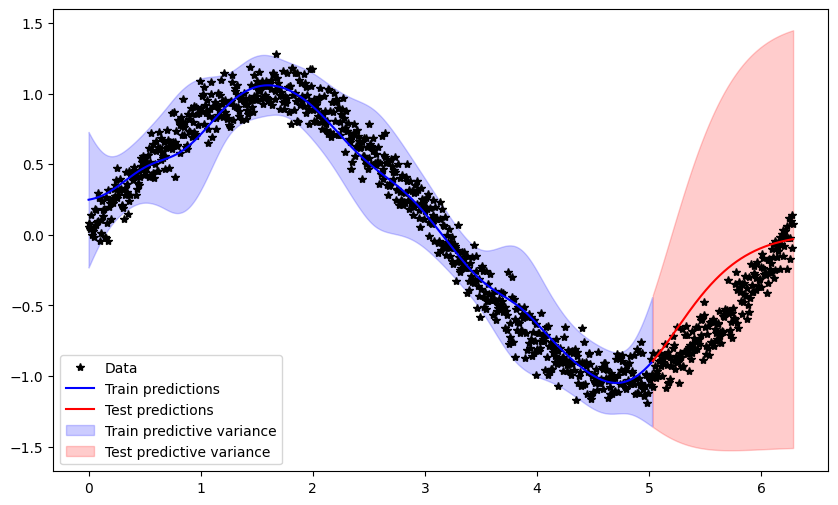

In [14]:
print('Test MAE: {}'.format(torch.mean(torch.abs(test_means - test_y.cpu()))))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X.numpy(), y.numpy(), 'k*', label='Data')
plt.plot(train_x.cpu().numpy(), train_means.numpy(), 'b', label='Train predictions')
plt.plot(test_x.cpu().numpy(), test_means.numpy(), 'r', label='Test predictions')

# Plot training variance as a shaded area
train_x_np = train_x.cpu().numpy()
train_means_np = train_means.numpy()
train_variances_np = train_variances.numpy()
plt.fill_between(train_x_np.squeeze(),
                 train_means_np - 2 * train_variances_np ** 0.5,
                 train_means_np + 2 * train_variances_np ** 0.5,
                 color='b', alpha=0.2, label='Train predictive variance')

# Plot test variance as a shaded area
test_x_np = test_x.cpu().numpy()
test_means_np = test_means.numpy()
test_variances_np = test_variances.numpy()
plt.fill_between(test_x_np.squeeze(),
                 test_means_np - 2 * test_variances_np ** 0.5,
                 test_means_np + 2 * test_variances_np ** 0.5,
                 color='r', alpha=0.2, label='Test predictive variance')

plt.legend()
plt.show()